In [1]:
import json

# Load the labeled proposals (assumed to be in the JSON format as described)
proposal_file_path = '/zhome/28/8/203659/UNI/Computer Vision DL/Segmentation/02516_poster_3/labeled_proposals_resized.json'  # Update with the actual path
with open(proposal_file_path, 'r') as f:
    proposals = json.load(f)


In [2]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
from PIL import Image
import os

class PotholeDatasetFromProposals(Dataset):
    def __init__(self, file_list, img_dir, proposals, transform=None):
        """
        Initialize the Pothole dataset using only the proposals JSON.
        
        Args:
            file_list (list): List of image filenames.
            img_dir (str): Directory where images are stored.
            proposals (dict): Proposed bounding boxes and labels for each image.
            transform (callable, optional): Optional transform to be applied on an image.
        """
        self.file_list = file_list
        self.img_dir = img_dir
        self.proposals = proposals
        self.transform = transform

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        # Get image filename
        img_name = self.file_list[idx]
        image_path = os.path.join(self.img_dir, img_name)
        
        # Load the image
        image = Image.open(image_path).convert("RGB")
        
        # Retrieve proposals for this image
        boxes = []
        labels = []
        for proposal in self.proposals.get(img_name, []):
            x, y, width, height = proposal["x_original"], proposal["y_original"], proposal["width_original"], proposal["height_original"]
            boxes.append([x, y, x + width, y + height])
            label = 0 if proposal['label'] == "background" else 1  # 0 for "background", 1 for "pothole"
            labels.append(label)
        
        # Convert to tensors
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        
        # Apply transformation to the image if specified
        if self.transform:
            image = self.transform(image)
        
        # Prepare target dictionary
        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        
        return image, target


In [3]:
# Define image directory and list of image files based on proposal keys
img_dir = '/zhome/28/8/203659/UNI/Computer Vision DL/Segmentation/02516_poster_3/Potholes/annotated-images'
file_list = list(proposals.keys())  # Image files in the proposals

# Define transformations
transform = T.Compose([
    T.Resize((200, 200)), # FOR NOW ALIGN WITH THE PROPOSALS, CHANGE DATALOADERS TO ALIGN WITH THE TRANSFORMS
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Initialize dataset with only proposals
dataset = PotholeDatasetFromProposals(
    file_list=file_list,
    img_dir=img_dir,
    proposals=proposals,
    transform=transform
)

# Define DataLoader
dataloader = DataLoader(dataset, batch_size=8, shuffle=True, num_workers=4, collate_fn=lambda x: tuple(zip(*x)))

# Example loop to access batched data
for images, targets in dataloader:
    print("Batch of images:", images)
    print("Batch of targets:", targets)
    break  # Display only the first batch


Batch of images: (tensor([[[-1.2617, -1.0904, -1.0562,  ..., -1.0562, -0.9192, -0.7993],
         [-1.2959, -1.0048, -1.1589,  ..., -0.9877, -0.9877, -1.1075],
         [-0.9877, -0.8678, -1.1075,  ..., -1.3987, -1.2617, -0.7308],
         ...,
         [ 1.1700,  0.9988,  1.2385,  ...,  0.7248,  1.1187,  1.0159],
         [ 1.1015,  0.9474,  1.0673,  ...,  1.0502,  1.2385,  0.9303],
         [ 1.1529,  1.0844,  1.0673,  ...,  0.9988,  1.1529,  1.2214]],

        [[-0.8978, -0.7052, -0.6877,  ..., -0.5476, -0.3725, -0.4951],
         [-0.9328, -0.6352, -0.7927,  ..., -0.5301, -0.5126, -0.8452],
         [-0.6352, -0.4951, -0.7402,  ..., -1.0553, -0.9153, -0.4776],
         ...,
         [ 1.0280,  0.8354,  1.1155,  ...,  0.6954,  1.0980,  0.9580],
         [ 0.9405,  0.7829,  0.9230,  ...,  1.0280,  1.2206,  0.8704],
         [ 0.9930,  0.9230,  0.9055,  ...,  0.9755,  1.1155,  1.1856]],

        [[-1.6824, -1.5256, -1.5256,  ..., -1.4907, -1.4384, -1.3861],
         [-1.6650, -1.4384,

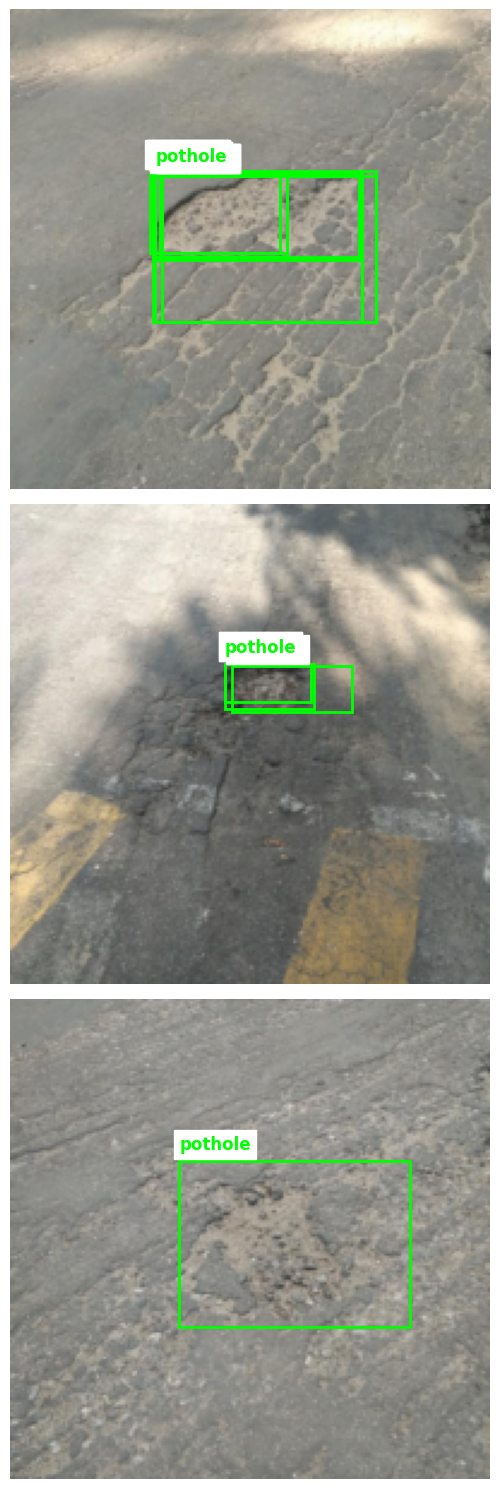

In [4]:
import matplotlib.pyplot as plt
import torch

def plot_sample_images(dataset, num_images=3):
    plt.figure(figsize=(15, 5 * num_images))
    for i in range(num_images):
        # Load image and target from dataset
        image, target = dataset[i]
        image_np = image.permute(1, 2, 0).numpy()  # Convert to numpy for plotting

        # Denormalize the image
        mean = [0.485, 0.456, 0.406]
        std = [0.229, 0.224, 0.225]
        image_np = image_np * std + mean  # Undo normalization
        image_np = (image_np * 255).astype("uint8")  # Convert to uint8 format for display

        # Check image dimensions (after potential resizing)
        target_size = image_np.shape[:2]  # New size (height, width)
        
        # Plot the image
        plt.subplot(num_images, 1, i + 1)
        plt.imshow(image_np)
        plt.axis("off")

        # Plot bounding boxes without scaling if images are not resized
        for box, label in zip(target['boxes'], target['labels']):
            if label == 1:
                x_min, y_min, x_max, y_max = box
                color = (0, 1, 0) if label == 1 else (1, 0, 0)  # Green for 'pothole', red for 'background'
                plt.gca().add_patch(plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, 
                                                linewidth=2, edgecolor=color, facecolor='none'))
                plt.text(x_min, y_min - 5, 'pothole' if label == 1 else 'background', 
                        color=color, fontsize=12, weight='bold', backgroundcolor="white")
        
    plt.tight_layout()
    plt.show()

# Usage example (make sure the dataset object is initialized):
plot_sample_images(dataset, num_images=3)


In [5]:
from sklearn.model_selection import train_test_split

# Define the split ratios
train_ratio = 0.7  # 70% of the data for training
val_ratio = 0.15   # 15% for validation
test_ratio = 0.15  # 15% for testing

# Create indices for the dataset
dataset_size = len(dataset)
indices = list(range(dataset_size))

# First split: training set and remaining set
train_indices, temp_indices = train_test_split(indices, test_size=(1 - train_ratio), random_state=42)

# Second split: validation and test set from the remaining set
val_size = int(len(temp_indices) * (val_ratio / (val_ratio + test_ratio)))  # Adjust for remaining size
val_indices, test_indices = temp_indices[:val_size], temp_indices[val_size:]


In [6]:
from torch.utils.data import Subset

# Create subsets for train, validation, and test sets
train_dataset = Subset(dataset, train_indices)
val_dataset = Subset(dataset, val_indices)
test_dataset = Subset(dataset, test_indices)


In [7]:
from torch.utils.data import DataLoader

# Define batch size
batch_size = 8

# Create DataLoaders for each subset
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, collate_fn=lambda x: tuple(zip(*x)))
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4, collate_fn=lambda x: tuple(zip(*x)))
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, collate_fn=lambda x: tuple(zip(*x)))
